## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [178]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [179]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential, K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [180]:
#import Gemma's function for removing outliers
sys.path.insert(0, './../Gemma/Part 1')
from outliers import removeOutliers

#import Riccardo's function for removing missing values
sys.path.insert(0, './../Riccardo')
from MissingValues_3 import remove_missing_values

#import Daniele's function for converting education into a numerical attribute
#import also Daniele's function for adding mean columns' value to the data frame
from dependencies import create_data_frame_avg

In [181]:
def convert_credit_default_to_numerical_attribute(credit_cards_input):    
    credit_default_column = credit_cards_input["credit_default"]
    credit_default_column_new = []
   
    for default_row  in credit_default_column:
        credit_default_column_new.append(default_to_number(default_row))
       
    credit_cards_input["credit_default"] = credit_default_column_new
    return credit_cards_input

def default_to_number(category):
    if category == "no":
        return 0
    elif category == "yes":
        return 1  

In [182]:
def convert_education_to_numerical_attribute(credit_cards_input):    
    education_column = credit_cards_input["education"]
    education_column_new = []
   
    for education_row  in education_column:
        education_column_new.append(educ_category_to_number(education_row))
       
    credit_cards_input["education"] = education_column_new
    return credit_cards_input

def educ_category_to_number(category):
    if category == "others":
        return 0
    elif category == "high school":
        return 1
    elif category == "university":
        return 2
    elif category == "graduate school":
        return 3

In [ ]:
#Load the training data
url = "../../Dataset/credit_default_train.csv"
credit_cards_df = pd.read_csv(url)

#firstly, remove missing values
credit_cards_no_missing_outliers = remove_missing_values(credit_cards_df)
#and remove outliers (this function operates in place)
removeOutliers(credit_cards_no_missing_outliers)
#create mean value columns
credit_cards_avg = create_data_frame_avg(credit_cards_no_missing_outliers, ["ba-apr", "ba-may", "ba-jun", "ba-jul", "ba-aug", "ba-sep"], ["pa-apr", "pa-may", "pa-jun", "pa-jul", "pa-aug", "pa-sep"],  ["ps-apr", "ps-may", "ps-jun", "ps-jul", "ps-aug", "ps-sep"])
credit_cards_edu_numerical = convert_education_to_numerical_attribute(credit_cards_avg)
#and convert the credit_default into a numerical attribute as well
credit_cards_default_num = convert_credit_default_to_numerical_attribute(credit_cards_edu_numerical)

#pick the attributes you wanna use for deep learning
attributes_deep_learning = ["limit", "age", "education", "limit", "pa", 'ps-may', 'ps-jun', 'ps-jul', 'ps-aug', 'ps-sep']
credit_cards_deep_learning_train = credit_cards_default_num[attributes_deep_learning]

In [208]:
#Load the training data
url = "../../Dataset/credit_default_test.csv"
credit_cards_df = pd.read_csv(url)

#firstly, remove missing values
credit_cards_no_missing_outliers = remove_missing_values(credit_cards_df)
#and remove outliers (this function operates in place)
removeOutliers(credit_cards_no_missing_outliers)
#create mean value columns
credit_cards_avg = create_data_frame_avg(credit_cards_no_missing_outliers, ["ba-apr", "ba-may", "ba-jun", "ba-jul", "ba-aug", "ba-sep"], ["pa-apr", "pa-may", "pa-jun", "pa-jul", "pa-aug", "pa-sep"],  ["ps-apr", "ps-may", "ps-jun", "ps-jul", "ps-aug", "ps-sep"])
credit_cards_edu_numerical = convert_education_to_numerical_attribute(credit_cards_avg)
#and convert the credit_default into a numerical attribute as well

#pick the attributes you wanna use for deep learning
attributes_deep_learning = ["limit", "age", "education", "limit", "pa", 'ps-may', 'ps-jun', 'ps-jul', 'ps-aug', 'ps-sep']
credit_cards_deep_learning_test = credit_cards_edu_numerical[attributes_deep_learning]

Initial size of data frame:  (20000, 24)
Visual analysis, number of rows to be dropped:  44
Final size of data frame:  (19956, 24)


In [192]:
# Take a peek at the data 
print(credit_cards_train.shape)
credit_cards_train.sample(5)


(9970, 6)


,limit,age,education,limit,pa,ps
746,180000,41.0,1,180000,4093.500000,-1.500000
628,30000,27.0,3,30000,1902.000000,0.000000
8267,130000,46.0,1,130000,1073.166667,0.000000
561,10000,26.0,2,10000,0.000000,5.333333
8869,30000,38.0,2,30000,1229.500000,0.333333


In [196]:
#Input: X is the dataframe without the credit_default label

X = credit_cards_train.iloc[:, :-1].values
#the output consists of the state with diabetes
y = credit_cards_default_num["credit_default"].values

print(X)

print(y)


[[5.00000000e+04 2.50000000e+01 3.00000000e+00 5.00000000e+04
  1.54100000e+03]
 [2.00000000e+05 5.40000000e+01 2.00000000e+00 2.00000000e+05
  7.06416667e+03]
 [3.00000000e+04 4.10000000e+01 1.00000000e+00 3.00000000e+04
  8.59833333e+02]
 ...
 [9.00000000e+04 4.70000000e+01 2.00000000e+00 9.00000000e+04
  2.00000000e+03]
 [2.00000000e+04 5.90000000e+01 2.00000000e+00 2.00000000e+04
  5.95500000e+02]
 [2.80000000e+05 3.50000000e+01 2.00000000e+00 2.80000000e+05
  4.82843333e+04]]
[0 0 0 ... 0 0 0]


In [197]:
np.mean(y), np.mean(1-y)

(0.22146439317953862, 0.7785356068204614)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [198]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
#we train both with X input data and Y input data
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [199]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test) #HARD
y_pred_prob_rf = rf_model.predict_proba(X_test) #SOFT


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.783
roc-auc is 0.717


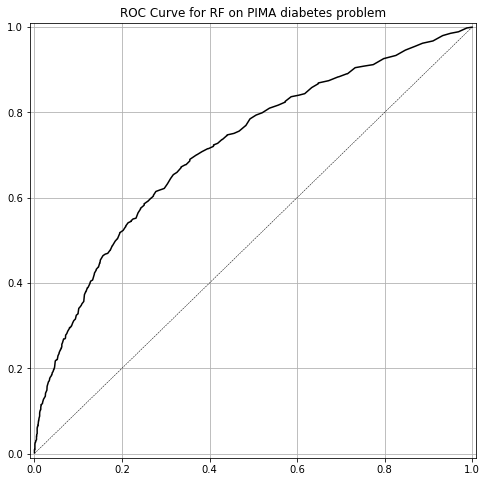

In [200]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [201]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [202]:
# Define the Model 
# Input size is 9-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)


model_1 = Sequential([
    Dense(12, input_shape=(9,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [203]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12)                120       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 13        
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?


Let's fit our model for 200 epochs.

In [204]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Train on 7477 samples, validate on 2493 samples
Epoch 1/200
7477/7477 [==============================] - 0s 46us/step - loss: 0.6089 - acc: 0.7055 - val_loss: 0.5690 - val_acc: 0.7621
Epoch 2/200
7477/7477 [==============================] - 0s 27us/step - loss: 0.5491 - acc: 0.7820 - val_loss: 0.5358 - val_acc: 0.7942
Epoch 3/200
7477/7477 [==============================] - 0s 27us/step - loss: 0.5256 - acc: 0.7963 - val_loss: 0.5214 - val_acc: 0.7886
Epoch 4/200
7477/7477 [==============================] - 0s 27us/step - loss: 0.5141 - acc: 0.7934 - val_loss: 0.5137 - val_acc: 0.7906
Epoch 5/200
7477/7477 [==============================] - 0s 26us/step - loss: 0.5074 - acc: 0.7928 - val_loss: 0.5088 - val_acc: 0.7894
Epoch 6/200
7477/7477 [==============================] - 0s 26us/step - loss: 0.5028 - acc: 0.7939 - val_loss: 0.5052 - val_acc: 0.7914
Epoch 7/200
7477/7477 [==============================] - 0s 26us/step - loss: 0.4994 - acc: 0.7952 - val_loss: 0.5024 - val_acc: 0.7922


7477/7477 [==============================] - 0s 28us/step - loss: 0.4689 - acc: 0.8043 - val_loss: 0.4729 - val_acc: 0.8059
Epoch 61/200
7477/7477 [==============================] - 0s 26us/step - loss: 0.4688 - acc: 0.8045 - val_loss: 0.4728 - val_acc: 0.8055
Epoch 62/200
7477/7477 [==============================] - 0s 28us/step - loss: 0.4687 - acc: 0.8045 - val_loss: 0.4727 - val_acc: 0.8055
Epoch 63/200
7477/7477 [==============================] - 0s 31us/step - loss: 0.4686 - acc: 0.8042 - val_loss: 0.4725 - val_acc: 0.8055
Epoch 64/200
7477/7477 [==============================] - 0s 25us/step - loss: 0.4685 - acc: 0.8050 - val_loss: 0.4724 - val_acc: 0.8055
Epoch 65/200
7477/7477 [==============================] - 0s 27us/step - loss: 0.4684 - acc: 0.8043 - val_loss: 0.4723 - val_acc: 0.8055
Epoch 66/200
7477/7477 [==============================] - 0s 31us/step - loss: 0.4683 - acc: 0.8046 - val_loss: 0.4722 - val_acc: 0.8055
Epoch 67/200
7477/7477 [==============================

Epoch 120/200
7477/7477 [==============================] - 0s 26us/step - loss: 0.4648 - acc: 0.8033 - val_loss: 0.4676 - val_acc: 0.8063
Epoch 121/200
7477/7477 [==============================] - 0s 26us/step - loss: 0.4648 - acc: 0.8034 - val_loss: 0.4675 - val_acc: 0.8063
Epoch 122/200
7477/7477 [==============================] - 0s 25us/step - loss: 0.4648 - acc: 0.8031 - val_loss: 0.4675 - val_acc: 0.8067
Epoch 123/200
7477/7477 [==============================] - 0s 25us/step - loss: 0.4647 - acc: 0.8033 - val_loss: 0.4674 - val_acc: 0.8067
Epoch 124/200
7477/7477 [==============================] - 0s 26us/step - loss: 0.4647 - acc: 0.8034 - val_loss: 0.4674 - val_acc: 0.8063
Epoch 125/200
7477/7477 [==============================] - 0s 25us/step - loss: 0.4646 - acc: 0.8034 - val_loss: 0.4674 - val_acc: 0.8063
Epoch 126/200
7477/7477 [==============================] - 0s 25us/step - loss: 0.4646 - acc: 0.8035 - val_loss: 0.4673 - val_acc: 0.8063
Epoch 127/200
7477/7477 [=========

7477/7477 [==============================] - 0s 24us/step - loss: 0.4629 - acc: 0.8042 - val_loss: 0.4653 - val_acc: 0.8055
Epoch 180/200
7477/7477 [==============================] - 0s 25us/step - loss: 0.4629 - acc: 0.8038 - val_loss: 0.4653 - val_acc: 0.8055
Epoch 181/200
7477/7477 [==============================] - 0s 24us/step - loss: 0.4629 - acc: 0.8037 - val_loss: 0.4653 - val_acc: 0.8055
Epoch 182/200
7477/7477 [==============================] - 0s 24us/step - loss: 0.4628 - acc: 0.8039 - val_loss: 0.4652 - val_acc: 0.8055
Epoch 183/200
7477/7477 [==============================] - 0s 24us/step - loss: 0.4628 - acc: 0.8037 - val_loss: 0.4652 - val_acc: 0.8055
Epoch 184/200
7477/7477 [==============================] - 0s 24us/step - loss: 0.4628 - acc: 0.8039 - val_loss: 0.4652 - val_acc: 0.8055
Epoch 185/200
7477/7477 [==============================] - 0s 24us/step - loss: 0.4627 - acc: 0.8038 - val_loss: 0.4652 - val_acc: 0.8059
Epoch 186/200
7477/7477 [=======================

In [156]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [157]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]
y_pred_class_nn_1 #Resulting prediction for every single data point

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [158]:
#predictions' results from the test casa
y_pred_prob_nn_1[:10]


array([[0.15656613],
       [0.11879377],
       [0.17529505],
       [0.24763307],
       [0.13805325],
       [0.36484885],
       [0.06943215],
       [0.02405155],
       [0.21637224],
       [0.06136973]], dtype=float32)

accuracy is 0.807
roc-auc is 0.731


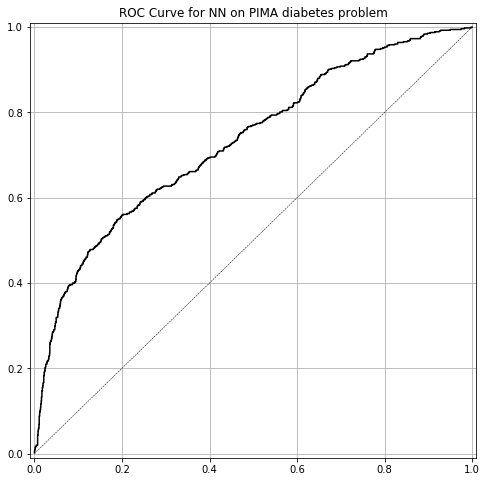

In [159]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [160]:
run_hist_1.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

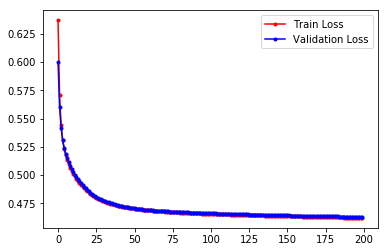

In [161]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [162]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Train on 7477 samples, validate on 2493 samples
Epoch 1/1000
7477/7477 [==============================] - 0s 34us/step - loss: 0.4621 - acc: 0.8038 - val_loss: 0.4632 - val_acc: 0.8067
Epoch 2/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4621 - acc: 0.8039 - val_loss: 0.4632 - val_acc: 0.8059
Epoch 3/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4620 - acc: 0.8038 - val_loss: 0.4631 - val_acc: 0.8063
Epoch 4/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4620 - acc: 0.8037 - val_loss: 0.4631 - val_acc: 0.8063
Epoch 5/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4620 - acc: 0.8037 - val_loss: 0.4631 - val_acc: 0.8059
Epoch 6/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4620 - acc: 0.8034 - val_loss: 0.4631 - val_acc: 0.8059
Epoch 7/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4619 - acc: 0.8039 - val_loss: 0.4631 - val_acc: 

7477/7477 [==============================] - 0s 25us/step - loss: 0.4607 - acc: 0.8039 - val_loss: 0.4622 - val_acc: 0.8059
Epoch 61/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4606 - acc: 0.8038 - val_loss: 0.4622 - val_acc: 0.8059
Epoch 62/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4606 - acc: 0.8045 - val_loss: 0.4622 - val_acc: 0.8059
Epoch 63/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4606 - acc: 0.8042 - val_loss: 0.4621 - val_acc: 0.8059
Epoch 64/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4606 - acc: 0.8043 - val_loss: 0.4621 - val_acc: 0.8059
Epoch 65/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4605 - acc: 0.8039 - val_loss: 0.4621 - val_acc: 0.8055
Epoch 66/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4605 - acc: 0.8042 - val_loss: 0.4621 - val_acc: 0.8043
Epoch 67/1000
7477/7477 [=======================

7477/7477 [==============================] - 0s 25us/step - loss: 0.4592 - acc: 0.8054 - val_loss: 0.4611 - val_acc: 0.8043
Epoch 120/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4592 - acc: 0.8053 - val_loss: 0.4611 - val_acc: 0.8043
Epoch 121/1000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4591 - acc: 0.8054 - val_loss: 0.4610 - val_acc: 0.8047
Epoch 122/1000
7477/7477 [==============================] - 0s 31us/step - loss: 0.4591 - acc: 0.8051 - val_loss: 0.4610 - val_acc: 0.8047
Epoch 123/1000
7477/7477 [==============================] - 0s 40us/step - loss: 0.4591 - acc: 0.8053 - val_loss: 0.4610 - val_acc: 0.8047
Epoch 124/1000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4591 - acc: 0.8054 - val_loss: 0.4610 - val_acc: 0.8047
Epoch 125/1000
7477/7477 [==============================] - 0s 31us/step - loss: 0.4590 - acc: 0.8054 - val_loss: 0.4610 - val_acc: 0.8047
Epoch 126/1000
7477/7477 [================

7477/7477 [==============================] - 0s 25us/step - loss: 0.4578 - acc: 0.8058 - val_loss: 0.4600 - val_acc: 0.8063
Epoch 179/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4577 - acc: 0.8058 - val_loss: 0.4600 - val_acc: 0.8063
Epoch 180/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4577 - acc: 0.8055 - val_loss: 0.4600 - val_acc: 0.8063
Epoch 181/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4577 - acc: 0.8058 - val_loss: 0.4599 - val_acc: 0.8063
Epoch 182/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4577 - acc: 0.8058 - val_loss: 0.4599 - val_acc: 0.8063
Epoch 183/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4577 - acc: 0.8053 - val_loss: 0.4599 - val_acc: 0.8059
Epoch 184/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4576 - acc: 0.8055 - val_loss: 0.4599 - val_acc: 0.8059
Epoch 185/1000
7477/7477 [================

7477/7477 [==============================] - 0s 32us/step - loss: 0.4566 - acc: 0.8059 - val_loss: 0.4591 - val_acc: 0.8067
Epoch 238/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4565 - acc: 0.8058 - val_loss: 0.4591 - val_acc: 0.8067
Epoch 239/1000
7477/7477 [==============================] - 0s 43us/step - loss: 0.4565 - acc: 0.8058 - val_loss: 0.4590 - val_acc: 0.8067
Epoch 240/1000
7477/7477 [==============================] - 0s 46us/step - loss: 0.4565 - acc: 0.8058 - val_loss: 0.4590 - val_acc: 0.8067
Epoch 241/1000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4565 - acc: 0.8057 - val_loss: 0.4590 - val_acc: 0.8067
Epoch 242/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4565 - acc: 0.8059 - val_loss: 0.4590 - val_acc: 0.8067
Epoch 243/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4564 - acc: 0.8059 - val_loss: 0.4590 - val_acc: 0.8067
Epoch 244/1000
7477/7477 [================

7477/7477 [==============================] - 0s 25us/step - loss: 0.4556 - acc: 0.8065 - val_loss: 0.4583 - val_acc: 0.8079
Epoch 297/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4555 - acc: 0.8065 - val_loss: 0.4583 - val_acc: 0.8079
Epoch 298/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4555 - acc: 0.8065 - val_loss: 0.4583 - val_acc: 0.8079
Epoch 299/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4555 - acc: 0.8065 - val_loss: 0.4583 - val_acc: 0.8079
Epoch 300/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4555 - acc: 0.8063 - val_loss: 0.4583 - val_acc: 0.8079
Epoch 301/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4555 - acc: 0.8066 - val_loss: 0.4583 - val_acc: 0.8079
Epoch 302/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4555 - acc: 0.8065 - val_loss: 0.4583 - val_acc: 0.8083
Epoch 303/1000
7477/7477 [================

7477/7477 [==============================] - 0s 25us/step - loss: 0.4548 - acc: 0.8065 - val_loss: 0.4577 - val_acc: 0.8067
Epoch 356/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4548 - acc: 0.8069 - val_loss: 0.4577 - val_acc: 0.8063
Epoch 357/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4548 - acc: 0.8069 - val_loss: 0.4577 - val_acc: 0.8063
Epoch 358/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4548 - acc: 0.8069 - val_loss: 0.4576 - val_acc: 0.8067
Epoch 359/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4548 - acc: 0.8067 - val_loss: 0.4576 - val_acc: 0.8063
Epoch 360/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4548 - acc: 0.8067 - val_loss: 0.4576 - val_acc: 0.8063
Epoch 361/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4548 - acc: 0.8067 - val_loss: 0.4576 - val_acc: 0.8063
Epoch 362/1000
7477/7477 [================

7477/7477 [==============================] - 0s 24us/step - loss: 0.4543 - acc: 0.8066 - val_loss: 0.4571 - val_acc: 0.8030
Epoch 415/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4543 - acc: 0.8070 - val_loss: 0.4571 - val_acc: 0.8030
Epoch 416/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4543 - acc: 0.8070 - val_loss: 0.4571 - val_acc: 0.8034
Epoch 417/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4543 - acc: 0.8070 - val_loss: 0.4570 - val_acc: 0.8034
Epoch 418/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4542 - acc: 0.8069 - val_loss: 0.4570 - val_acc: 0.8039
Epoch 419/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4542 - acc: 0.8069 - val_loss: 0.4570 - val_acc: 0.8034
Epoch 420/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4542 - acc: 0.8066 - val_loss: 0.4570 - val_acc: 0.8039
Epoch 421/1000
7477/7477 [================

7477/7477 [==============================] - 0s 24us/step - loss: 0.4538 - acc: 0.8074 - val_loss: 0.4565 - val_acc: 0.8030
Epoch 474/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4538 - acc: 0.8077 - val_loss: 0.4565 - val_acc: 0.8030
Epoch 475/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4538 - acc: 0.8074 - val_loss: 0.4565 - val_acc: 0.8030
Epoch 476/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4538 - acc: 0.8074 - val_loss: 0.4565 - val_acc: 0.8030
Epoch 477/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4538 - acc: 0.8075 - val_loss: 0.4565 - val_acc: 0.8030
Epoch 478/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4538 - acc: 0.8075 - val_loss: 0.4564 - val_acc: 0.8026
Epoch 479/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4538 - acc: 0.8075 - val_loss: 0.4565 - val_acc: 0.8030
Epoch 480/1000
7477/7477 [================

7477/7477 [==============================] - 0s 24us/step - loss: 0.4534 - acc: 0.8083 - val_loss: 0.4560 - val_acc: 0.8055
Epoch 533/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4534 - acc: 0.8081 - val_loss: 0.4560 - val_acc: 0.8055
Epoch 534/1000
7477/7477 [==============================] - 0s 36us/step - loss: 0.4534 - acc: 0.8085 - val_loss: 0.4560 - val_acc: 0.8055
Epoch 535/1000
7477/7477 [==============================] - 0s 33us/step - loss: 0.4534 - acc: 0.8079 - val_loss: 0.4560 - val_acc: 0.8059
Epoch 536/1000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4534 - acc: 0.8081 - val_loss: 0.4560 - val_acc: 0.8059
Epoch 537/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4534 - acc: 0.8078 - val_loss: 0.4560 - val_acc: 0.8059
Epoch 538/1000
7477/7477 [==============================] - 0s 35us/step - loss: 0.4534 - acc: 0.8077 - val_loss: 0.4559 - val_acc: 0.8055
Epoch 539/1000
7477/7477 [================

7477/7477 [==============================] - 0s 26us/step - loss: 0.4530 - acc: 0.8077 - val_loss: 0.4557 - val_acc: 0.8063
Epoch 592/1000
7477/7477 [==============================] - 0s 39us/step - loss: 0.4530 - acc: 0.8078 - val_loss: 0.4556 - val_acc: 0.8063
Epoch 593/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4530 - acc: 0.8079 - val_loss: 0.4557 - val_acc: 0.8063
Epoch 594/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4530 - acc: 0.8078 - val_loss: 0.4556 - val_acc: 0.8063
Epoch 595/1000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4530 - acc: 0.8089 - val_loss: 0.4556 - val_acc: 0.8063
Epoch 596/1000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4530 - acc: 0.8082 - val_loss: 0.4556 - val_acc: 0.8063
Epoch 597/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4530 - acc: 0.8082 - val_loss: 0.4556 - val_acc: 0.8063
Epoch 598/1000
7477/7477 [================

7477/7477 [==============================] - 0s 31us/step - loss: 0.4527 - acc: 0.8085 - val_loss: 0.4554 - val_acc: 0.8055
Epoch 651/1000
7477/7477 [==============================] - 0s 35us/step - loss: 0.4527 - acc: 0.8083 - val_loss: 0.4553 - val_acc: 0.8055
Epoch 652/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4527 - acc: 0.8078 - val_loss: 0.4553 - val_acc: 0.8059
Epoch 653/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4527 - acc: 0.8082 - val_loss: 0.4553 - val_acc: 0.8055
Epoch 654/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4527 - acc: 0.8079 - val_loss: 0.4553 - val_acc: 0.8055
Epoch 655/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4527 - acc: 0.8081 - val_loss: 0.4553 - val_acc: 0.8055
Epoch 656/1000
7477/7477 [==============================] - 0s 37us/step - loss: 0.4527 - acc: 0.8081 - val_loss: 0.4553 - val_acc: 0.8059
Epoch 657/1000
7477/7477 [================

7477/7477 [==============================] - 0s 25us/step - loss: 0.4524 - acc: 0.8079 - val_loss: 0.4549 - val_acc: 0.8043
Epoch 710/1000
7477/7477 [==============================] - 0s 36us/step - loss: 0.4524 - acc: 0.8075 - val_loss: 0.4549 - val_acc: 0.8047
Epoch 711/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4524 - acc: 0.8077 - val_loss: 0.4550 - val_acc: 0.8039
Epoch 712/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4524 - acc: 0.8079 - val_loss: 0.4550 - val_acc: 0.8039
Epoch 713/1000
7477/7477 [==============================] - 0s 36us/step - loss: 0.4524 - acc: 0.8075 - val_loss: 0.4549 - val_acc: 0.8039
Epoch 714/1000
7477/7477 [==============================] - 0s 34us/step - loss: 0.4524 - acc: 0.8078 - val_loss: 0.4550 - val_acc: 0.8039
Epoch 715/1000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4524 - acc: 0.8079 - val_loss: 0.4550 - val_acc: 0.8043
Epoch 716/1000
7477/7477 [================

7477/7477 [==============================] - 0s 29us/step - loss: 0.4521 - acc: 0.8074 - val_loss: 0.4548 - val_acc: 0.8051
Epoch 769/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4521 - acc: 0.8081 - val_loss: 0.4548 - val_acc: 0.8047
Epoch 770/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4521 - acc: 0.8075 - val_loss: 0.4548 - val_acc: 0.8051
Epoch 771/1000
7477/7477 [==============================] - 0s 34us/step - loss: 0.4521 - acc: 0.8082 - val_loss: 0.4548 - val_acc: 0.8051
Epoch 772/1000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4521 - acc: 0.8081 - val_loss: 0.4548 - val_acc: 0.8051
Epoch 773/1000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4520 - acc: 0.8079 - val_loss: 0.4548 - val_acc: 0.8051
Epoch 774/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4521 - acc: 0.8077 - val_loss: 0.4548 - val_acc: 0.8047
Epoch 775/1000
7477/7477 [================

7477/7477 [==============================] - 0s 27us/step - loss: 0.4518 - acc: 0.8095 - val_loss: 0.4547 - val_acc: 0.8043
Epoch 828/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4518 - acc: 0.8090 - val_loss: 0.4547 - val_acc: 0.8043
Epoch 829/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4518 - acc: 0.8085 - val_loss: 0.4547 - val_acc: 0.8039
Epoch 830/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4518 - acc: 0.8091 - val_loss: 0.4548 - val_acc: 0.8039
Epoch 831/1000
7477/7477 [==============================] - 0s 33us/step - loss: 0.4518 - acc: 0.8086 - val_loss: 0.4548 - val_acc: 0.8039
Epoch 832/1000
7477/7477 [==============================] - 0s 33us/step - loss: 0.4518 - acc: 0.8090 - val_loss: 0.4547 - val_acc: 0.8039
Epoch 833/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4518 - acc: 0.8091 - val_loss: 0.4548 - val_acc: 0.8043
Epoch 834/1000
7477/7477 [================

7477/7477 [==============================] - 0s 23us/step - loss: 0.4516 - acc: 0.8087 - val_loss: 0.4547 - val_acc: 0.8047
Epoch 887/1000
7477/7477 [==============================] - 0s 23us/step - loss: 0.4516 - acc: 0.8089 - val_loss: 0.4547 - val_acc: 0.8047
Epoch 888/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4516 - acc: 0.8091 - val_loss: 0.4547 - val_acc: 0.8047
Epoch 889/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4516 - acc: 0.8086 - val_loss: 0.4547 - val_acc: 0.8047
Epoch 890/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4516 - acc: 0.8086 - val_loss: 0.4547 - val_acc: 0.8047
Epoch 891/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4516 - acc: 0.8086 - val_loss: 0.4547 - val_acc: 0.8047
Epoch 892/1000
7477/7477 [==============================] - 0s 32us/step - loss: 0.4515 - acc: 0.8093 - val_loss: 0.4547 - val_acc: 0.8043
Epoch 893/1000
7477/7477 [================

7477/7477 [==============================] - 0s 24us/step - loss: 0.4513 - acc: 0.8090 - val_loss: 0.4546 - val_acc: 0.8051
Epoch 946/1000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4513 - acc: 0.8090 - val_loss: 0.4546 - val_acc: 0.8047
Epoch 947/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4513 - acc: 0.8089 - val_loss: 0.4545 - val_acc: 0.8051
Epoch 948/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4513 - acc: 0.8093 - val_loss: 0.4545 - val_acc: 0.8051
Epoch 949/1000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4513 - acc: 0.8089 - val_loss: 0.4545 - val_acc: 0.8051
Epoch 950/1000
7477/7477 [==============================] - 0s 33us/step - loss: 0.4513 - acc: 0.8095 - val_loss: 0.4545 - val_acc: 0.8051
Epoch 951/1000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4512 - acc: 0.8091 - val_loss: 0.4546 - val_acc: 0.8051
Epoch 952/1000
7477/7477 [================

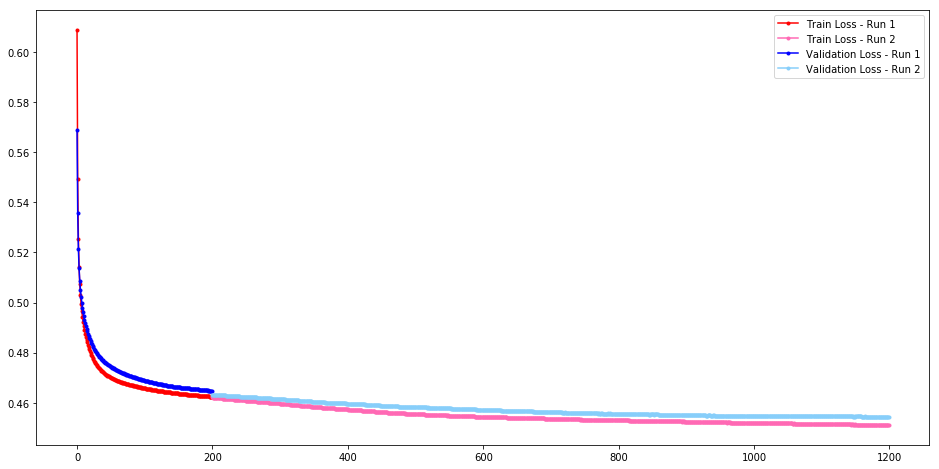

In [205]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise
Now it's your turn.  Do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [164]:
1.# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 6 hidden nodes, relu activation
# 1 hidden layer, 6 hidden nodes, relu activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)


model_2 = Sequential([
    #hidden layers
    Dense(6, input_shape=(9,), activation="relu"),
    Dense(6, activation="relu"),
    #final layer
    Dense(1, activation="sigmoid")
])

In [165]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


In [166]:
model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])

In [167]:
#Train function!!
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Train on 7477 samples, validate on 2493 samples
Epoch 1/1500
7477/7477 [==============================] - 0s 49us/step - loss: 0.6164 - acc: 0.7018 - val_loss: 0.5950 - val_acc: 0.7497
Epoch 2/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.5705 - acc: 0.7686 - val_loss: 0.5690 - val_acc: 0.7714
Epoch 3/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.5510 - acc: 0.7781 - val_loss: 0.5551 - val_acc: 0.7746
Epoch 4/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.5389 - acc: 0.7785 - val_loss: 0.5448 - val_acc: 0.7770
Epoch 5/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.5297 - acc: 0.7789 - val_loss: 0.5366 - val_acc: 0.7766
Epoch 6/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.5224 - acc: 0.7801 - val_loss: 0.5296 - val_acc: 0.7778
Epoch 7/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.5162 - acc: 0.7813 - val_loss: 0.5235 - val_acc: 

7477/7477 [==============================] - 0s 26us/step - loss: 0.4652 - acc: 0.8041 - val_loss: 0.4666 - val_acc: 0.8026
Epoch 61/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4651 - acc: 0.8041 - val_loss: 0.4664 - val_acc: 0.8030
Epoch 62/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4651 - acc: 0.8037 - val_loss: 0.4663 - val_acc: 0.8030
Epoch 63/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4650 - acc: 0.8037 - val_loss: 0.4663 - val_acc: 0.8030
Epoch 64/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4650 - acc: 0.8041 - val_loss: 0.4662 - val_acc: 0.8026
Epoch 65/1500
7477/7477 [==============================] - 0s 31us/step - loss: 0.4649 - acc: 0.8037 - val_loss: 0.4661 - val_acc: 0.8030
Epoch 66/1500
7477/7477 [==============================] - 0s 34us/step - loss: 0.4648 - acc: 0.8035 - val_loss: 0.4660 - val_acc: 0.8026
Epoch 67/1500
7477/7477 [=======================

7477/7477 [==============================] - 0s 27us/step - loss: 0.4623 - acc: 0.8031 - val_loss: 0.4634 - val_acc: 0.8043
Epoch 120/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.4622 - acc: 0.8037 - val_loss: 0.4634 - val_acc: 0.8043
Epoch 121/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.4622 - acc: 0.8034 - val_loss: 0.4634 - val_acc: 0.8043
Epoch 122/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4622 - acc: 0.8034 - val_loss: 0.4633 - val_acc: 0.8039
Epoch 123/1500
7477/7477 [==============================] - 0s 38us/step - loss: 0.4621 - acc: 0.8033 - val_loss: 0.4633 - val_acc: 0.8039
Epoch 124/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.4621 - acc: 0.8033 - val_loss: 0.4633 - val_acc: 0.8043
Epoch 125/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4621 - acc: 0.8035 - val_loss: 0.4632 - val_acc: 0.8039
Epoch 126/1500
7477/7477 [================

7477/7477 [==============================] - 0s 35us/step - loss: 0.4608 - acc: 0.8037 - val_loss: 0.4617 - val_acc: 0.8047
Epoch 179/1500
7477/7477 [==============================] - 0s 31us/step - loss: 0.4607 - acc: 0.8037 - val_loss: 0.4617 - val_acc: 0.8047
Epoch 180/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.4607 - acc: 0.8033 - val_loss: 0.4617 - val_acc: 0.8047
Epoch 181/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4607 - acc: 0.8037 - val_loss: 0.4617 - val_acc: 0.8051
Epoch 182/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4607 - acc: 0.8042 - val_loss: 0.4616 - val_acc: 0.8047
Epoch 183/1500
7477/7477 [==============================] - 0s 29us/step - loss: 0.4607 - acc: 0.8035 - val_loss: 0.4616 - val_acc: 0.8051
Epoch 184/1500
7477/7477 [==============================] - 0s 32us/step - loss: 0.4607 - acc: 0.8038 - val_loss: 0.4616 - val_acc: 0.8047
Epoch 185/1500
7477/7477 [================

7477/7477 [==============================] - 0s 28us/step - loss: 0.4595 - acc: 0.8041 - val_loss: 0.4603 - val_acc: 0.8047
Epoch 238/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.4595 - acc: 0.8041 - val_loss: 0.4603 - val_acc: 0.8047
Epoch 239/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4595 - acc: 0.8039 - val_loss: 0.4603 - val_acc: 0.8051
Epoch 240/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.4595 - acc: 0.8039 - val_loss: 0.4603 - val_acc: 0.8047
Epoch 241/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4595 - acc: 0.8037 - val_loss: 0.4603 - val_acc: 0.8047
Epoch 242/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4594 - acc: 0.8035 - val_loss: 0.4602 - val_acc: 0.8047
Epoch 243/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.4594 - acc: 0.8037 - val_loss: 0.4602 - val_acc: 0.8043
Epoch 244/1500
7477/7477 [================

7477/7477 [==============================] - 0s 26us/step - loss: 0.4585 - acc: 0.8038 - val_loss: 0.4590 - val_acc: 0.8067
Epoch 297/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4585 - acc: 0.8038 - val_loss: 0.4590 - val_acc: 0.8067
Epoch 298/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4585 - acc: 0.8034 - val_loss: 0.4590 - val_acc: 0.8067
Epoch 299/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4585 - acc: 0.8042 - val_loss: 0.4590 - val_acc: 0.8067
Epoch 300/1500
7477/7477 [==============================] - 0s 26us/step - loss: 0.4585 - acc: 0.8041 - val_loss: 0.4590 - val_acc: 0.8055
Epoch 301/1500
7477/7477 [==============================] - 0s 26us/step - loss: 0.4585 - acc: 0.8037 - val_loss: 0.4590 - val_acc: 0.8067
Epoch 302/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4584 - acc: 0.8042 - val_loss: 0.4589 - val_acc: 0.8067
Epoch 303/1500
7477/7477 [================

7477/7477 [==============================] - 0s 27us/step - loss: 0.4575 - acc: 0.8046 - val_loss: 0.4574 - val_acc: 0.8071
Epoch 356/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.4575 - acc: 0.8047 - val_loss: 0.4574 - val_acc: 0.8071
Epoch 357/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.4575 - acc: 0.8047 - val_loss: 0.4573 - val_acc: 0.8071
Epoch 358/1500
7477/7477 [==============================] - 0s 26us/step - loss: 0.4575 - acc: 0.8049 - val_loss: 0.4573 - val_acc: 0.8071
Epoch 359/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4574 - acc: 0.8049 - val_loss: 0.4573 - val_acc: 0.8067
Epoch 360/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4574 - acc: 0.8050 - val_loss: 0.4572 - val_acc: 0.8063
Epoch 361/1500
7477/7477 [==============================] - 0s 29us/step - loss: 0.4574 - acc: 0.8049 - val_loss: 0.4572 - val_acc: 0.8059
Epoch 362/1500
7477/7477 [================

7477/7477 [==============================] - 0s 27us/step - loss: 0.4564 - acc: 0.8042 - val_loss: 0.4557 - val_acc: 0.8047
Epoch 415/1500
7477/7477 [==============================] - 0s 26us/step - loss: 0.4564 - acc: 0.8046 - val_loss: 0.4556 - val_acc: 0.8043
Epoch 416/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.4564 - acc: 0.8045 - val_loss: 0.4556 - val_acc: 0.8051
Epoch 417/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4564 - acc: 0.8045 - val_loss: 0.4556 - val_acc: 0.8047
Epoch 418/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4564 - acc: 0.8047 - val_loss: 0.4556 - val_acc: 0.8043
Epoch 419/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.4563 - acc: 0.8051 - val_loss: 0.4556 - val_acc: 0.8051
Epoch 420/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4563 - acc: 0.8046 - val_loss: 0.4556 - val_acc: 0.8051
Epoch 421/1500
7477/7477 [================

7477/7477 [==============================] - 0s 26us/step - loss: 0.4556 - acc: 0.8050 - val_loss: 0.4549 - val_acc: 0.8034
Epoch 474/1500
7477/7477 [==============================] - 0s 36us/step - loss: 0.4556 - acc: 0.8049 - val_loss: 0.4549 - val_acc: 0.8034
Epoch 475/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4556 - acc: 0.8054 - val_loss: 0.4548 - val_acc: 0.8039
Epoch 476/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4556 - acc: 0.8047 - val_loss: 0.4548 - val_acc: 0.8034
Epoch 477/1500
7477/7477 [==============================] - 0s 30us/step - loss: 0.4556 - acc: 0.8053 - val_loss: 0.4548 - val_acc: 0.8034
Epoch 478/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4556 - acc: 0.8049 - val_loss: 0.4548 - val_acc: 0.8034
Epoch 479/1500
7477/7477 [==============================] - 0s 34us/step - loss: 0.4555 - acc: 0.8055 - val_loss: 0.4548 - val_acc: 0.8034
Epoch 480/1500
7477/7477 [================

7477/7477 [==============================] - 0s 39us/step - loss: 0.4551 - acc: 0.8053 - val_loss: 0.4544 - val_acc: 0.8043
Epoch 533/1500
7477/7477 [==============================] - 0s 27us/step - loss: 0.4551 - acc: 0.8049 - val_loss: 0.4544 - val_acc: 0.8047
Epoch 534/1500
7477/7477 [==============================] - 0s 35us/step - loss: 0.4551 - acc: 0.8050 - val_loss: 0.4544 - val_acc: 0.8043
Epoch 535/1500
7477/7477 [==============================] - 0s 28us/step - loss: 0.4551 - acc: 0.8051 - val_loss: 0.4544 - val_acc: 0.8043
Epoch 536/1500
7477/7477 [==============================] - 0s 33us/step - loss: 0.4551 - acc: 0.8045 - val_loss: 0.4544 - val_acc: 0.8051
Epoch 537/1500
7477/7477 [==============================] - 0s 31us/step - loss: 0.4551 - acc: 0.8054 - val_loss: 0.4543 - val_acc: 0.8051
Epoch 538/1500
7477/7477 [==============================] - 0s 30us/step - loss: 0.4550 - acc: 0.8053 - val_loss: 0.4543 - val_acc: 0.8051
Epoch 539/1500
7477/7477 [================

KeyboardInterrupt: 

In [206]:
#There is not a big improvement when training with 2x as many epochs
run_hist_2b = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=3000)


Train on 7477 samples, validate on 2493 samples
Epoch 1/3000
7477/7477 [==============================] - 0s 30us/step - loss: 0.4550 - acc: 0.8049 - val_loss: 0.4543 - val_acc: 0.8043
Epoch 2/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4549 - acc: 0.8055 - val_loss: 0.4542 - val_acc: 0.8047
Epoch 3/3000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4549 - acc: 0.8053 - val_loss: 0.4543 - val_acc: 0.8047
Epoch 4/3000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4549 - acc: 0.8051 - val_loss: 0.4543 - val_acc: 0.8039
Epoch 5/3000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4549 - acc: 0.8049 - val_loss: 0.4543 - val_acc: 0.8047
Epoch 6/3000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4549 - acc: 0.8053 - val_loss: 0.4543 - val_acc: 0.8051
Epoch 7/3000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4549 - acc: 0.8059 - val_loss: 0.4542 - val_acc: 

7477/7477 [==============================] - 0s 42us/step - loss: 0.4545 - acc: 0.8055 - val_loss: 0.4539 - val_acc: 0.8059
Epoch 61/3000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4545 - acc: 0.8057 - val_loss: 0.4539 - val_acc: 0.8059
Epoch 62/3000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4545 - acc: 0.8050 - val_loss: 0.4539 - val_acc: 0.8059
Epoch 63/3000
7477/7477 [==============================] - 0s 36us/step - loss: 0.4545 - acc: 0.8051 - val_loss: 0.4539 - val_acc: 0.8063
Epoch 64/3000
7477/7477 [==============================] - 0s 32us/step - loss: 0.4545 - acc: 0.8058 - val_loss: 0.4539 - val_acc: 0.8059
Epoch 65/3000
7477/7477 [==============================] - 0s 30us/step - loss: 0.4545 - acc: 0.8057 - val_loss: 0.4539 - val_acc: 0.8059
Epoch 66/3000
7477/7477 [==============================] - 0s 32us/step - loss: 0.4545 - acc: 0.8050 - val_loss: 0.4540 - val_acc: 0.8059
Epoch 67/3000
7477/7477 [=======================

7477/7477 [==============================] - 0s 35us/step - loss: 0.4541 - acc: 0.8058 - val_loss: 0.4541 - val_acc: 0.8055
Epoch 120/3000
7477/7477 [==============================] - 0s 33us/step - loss: 0.4541 - acc: 0.8055 - val_loss: 0.4541 - val_acc: 0.8063
Epoch 121/3000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4541 - acc: 0.8061 - val_loss: 0.4541 - val_acc: 0.8059
Epoch 122/3000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4541 - acc: 0.8059 - val_loss: 0.4541 - val_acc: 0.8051
Epoch 123/3000
7477/7477 [==============================] - 0s 41us/step - loss: 0.4541 - acc: 0.8054 - val_loss: 0.4541 - val_acc: 0.8059
Epoch 124/3000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4541 - acc: 0.8055 - val_loss: 0.4541 - val_acc: 0.8051
Epoch 125/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4541 - acc: 0.8055 - val_loss: 0.4540 - val_acc: 0.8059
Epoch 126/3000
7477/7477 [================

7477/7477 [==============================] - 0s 34us/step - loss: 0.4538 - acc: 0.8055 - val_loss: 0.4539 - val_acc: 0.8055
Epoch 179/3000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4537 - acc: 0.8058 - val_loss: 0.4539 - val_acc: 0.8051
Epoch 180/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4538 - acc: 0.8065 - val_loss: 0.4539 - val_acc: 0.8047
Epoch 181/3000
7477/7477 [==============================] - 0s 30us/step - loss: 0.4537 - acc: 0.8054 - val_loss: 0.4539 - val_acc: 0.8055
Epoch 182/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4538 - acc: 0.8063 - val_loss: 0.4539 - val_acc: 0.8047
Epoch 183/3000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4537 - acc: 0.8061 - val_loss: 0.4539 - val_acc: 0.8051
Epoch 184/3000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4537 - acc: 0.8065 - val_loss: 0.4539 - val_acc: 0.8047
Epoch 185/3000
7477/7477 [================

7477/7477 [==============================] - 0s 28us/step - loss: 0.4535 - acc: 0.8069 - val_loss: 0.4537 - val_acc: 0.8067
Epoch 238/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4535 - acc: 0.8063 - val_loss: 0.4538 - val_acc: 0.8063
Epoch 239/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4535 - acc: 0.8073 - val_loss: 0.4538 - val_acc: 0.8063
Epoch 240/3000
7477/7477 [==============================] - 0s 30us/step - loss: 0.4535 - acc: 0.8063 - val_loss: 0.4538 - val_acc: 0.8063
Epoch 241/3000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4535 - acc: 0.8067 - val_loss: 0.4538 - val_acc: 0.8067
Epoch 242/3000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4535 - acc: 0.8067 - val_loss: 0.4538 - val_acc: 0.8067
Epoch 243/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4535 - acc: 0.8070 - val_loss: 0.4538 - val_acc: 0.8067
Epoch 244/3000
7477/7477 [================

7477/7477 [==============================] - 0s 29us/step - loss: 0.4533 - acc: 0.8069 - val_loss: 0.4538 - val_acc: 0.8079
Epoch 297/3000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4533 - acc: 0.8067 - val_loss: 0.4537 - val_acc: 0.8067
Epoch 298/3000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4533 - acc: 0.8066 - val_loss: 0.4537 - val_acc: 0.8067
Epoch 299/3000
7477/7477 [==============================] - 0s 33us/step - loss: 0.4533 - acc: 0.8069 - val_loss: 0.4536 - val_acc: 0.8071
Epoch 300/3000
7477/7477 [==============================] - 0s 33us/step - loss: 0.4532 - acc: 0.8067 - val_loss: 0.4536 - val_acc: 0.8075
Epoch 301/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4533 - acc: 0.8069 - val_loss: 0.4536 - val_acc: 0.8071
Epoch 302/3000
7477/7477 [==============================] - 0s 35us/step - loss: 0.4532 - acc: 0.8066 - val_loss: 0.4536 - val_acc: 0.8071
Epoch 303/3000
7477/7477 [================

7477/7477 [==============================] - 0s 29us/step - loss: 0.4530 - acc: 0.8058 - val_loss: 0.4536 - val_acc: 0.8067
Epoch 356/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4531 - acc: 0.8073 - val_loss: 0.4535 - val_acc: 0.8059
Epoch 357/3000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4530 - acc: 0.8071 - val_loss: 0.4536 - val_acc: 0.8059
Epoch 358/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4531 - acc: 0.8069 - val_loss: 0.4536 - val_acc: 0.8063
Epoch 359/3000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4531 - acc: 0.8069 - val_loss: 0.4536 - val_acc: 0.8059
Epoch 360/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4530 - acc: 0.8063 - val_loss: 0.4537 - val_acc: 0.8067
Epoch 361/3000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4530 - acc: 0.8071 - val_loss: 0.4536 - val_acc: 0.8059
Epoch 362/3000
7477/7477 [================

7477/7477 [==============================] - 0s 27us/step - loss: 0.4528 - acc: 0.8069 - val_loss: 0.4537 - val_acc: 0.8059
Epoch 415/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4529 - acc: 0.8067 - val_loss: 0.4537 - val_acc: 0.8059
Epoch 416/3000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4528 - acc: 0.8069 - val_loss: 0.4538 - val_acc: 0.8063
Epoch 417/3000
7477/7477 [==============================] - 0s 36us/step - loss: 0.4529 - acc: 0.8074 - val_loss: 0.4538 - val_acc: 0.8059
Epoch 418/3000
7477/7477 [==============================] - 0s 39us/step - loss: 0.4529 - acc: 0.8070 - val_loss: 0.4538 - val_acc: 0.8063
Epoch 419/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4529 - acc: 0.8067 - val_loss: 0.4537 - val_acc: 0.8063
Epoch 420/3000
7477/7477 [==============================] - 0s 34us/step - loss: 0.4529 - acc: 0.8071 - val_loss: 0.4536 - val_acc: 0.8059
Epoch 421/3000
7477/7477 [================

7477/7477 [==============================] - 0s 37us/step - loss: 0.4526 - acc: 0.8079 - val_loss: 0.4537 - val_acc: 0.8071
Epoch 474/3000
7477/7477 [==============================] - 0s 29us/step - loss: 0.4526 - acc: 0.8073 - val_loss: 0.4537 - val_acc: 0.8071
Epoch 475/3000
7477/7477 [==============================] - 0s 38us/step - loss: 0.4526 - acc: 0.8075 - val_loss: 0.4536 - val_acc: 0.8071
Epoch 476/3000
7477/7477 [==============================] - 0s 30us/step - loss: 0.4527 - acc: 0.8075 - val_loss: 0.4537 - val_acc: 0.8079
Epoch 477/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4526 - acc: 0.8071 - val_loss: 0.4536 - val_acc: 0.8059
Epoch 478/3000
7477/7477 [==============================] - 0s 39us/step - loss: 0.4526 - acc: 0.8074 - val_loss: 0.4537 - val_acc: 0.8059
Epoch 479/3000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4526 - acc: 0.8074 - val_loss: 0.4536 - val_acc: 0.8067
Epoch 480/3000
7477/7477 [================

7477/7477 [==============================] - 0s 31us/step - loss: 0.4523 - acc: 0.8081 - val_loss: 0.4537 - val_acc: 0.8071
Epoch 533/3000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4523 - acc: 0.8089 - val_loss: 0.4537 - val_acc: 0.8079
Epoch 534/3000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4523 - acc: 0.8083 - val_loss: 0.4537 - val_acc: 0.8083
Epoch 535/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4523 - acc: 0.8087 - val_loss: 0.4537 - val_acc: 0.8079
Epoch 536/3000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4523 - acc: 0.8090 - val_loss: 0.4536 - val_acc: 0.8087
Epoch 537/3000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4523 - acc: 0.8086 - val_loss: 0.4537 - val_acc: 0.8083
Epoch 538/3000
7477/7477 [==============================] - 0s 24us/step - loss: 0.4523 - acc: 0.8086 - val_loss: 0.4536 - val_acc: 0.8079
Epoch 539/3000
7477/7477 [================

7477/7477 [==============================] - 0s 25us/step - loss: 0.4521 - acc: 0.8093 - val_loss: 0.4536 - val_acc: 0.8087
Epoch 592/3000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4521 - acc: 0.8085 - val_loss: 0.4536 - val_acc: 0.8079
Epoch 593/3000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4520 - acc: 0.8093 - val_loss: 0.4536 - val_acc: 0.8087
Epoch 594/3000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4521 - acc: 0.8093 - val_loss: 0.4536 - val_acc: 0.8083
Epoch 595/3000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4520 - acc: 0.8093 - val_loss: 0.4535 - val_acc: 0.8071
Epoch 596/3000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4520 - acc: 0.8094 - val_loss: 0.4535 - val_acc: 0.8075
Epoch 597/3000
7477/7477 [==============================] - 0s 25us/step - loss: 0.4520 - acc: 0.8091 - val_loss: 0.4536 - val_acc: 0.8079
Epoch 598/3000
7477/7477 [================

7477/7477 [==============================] - 0s 44us/step - loss: 0.4518 - acc: 0.8093 - val_loss: 0.4533 - val_acc: 0.8083
Epoch 651/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4518 - acc: 0.8093 - val_loss: 0.4534 - val_acc: 0.8091
Epoch 652/3000
7477/7477 [==============================] - 0s 34us/step - loss: 0.4518 - acc: 0.8095 - val_loss: 0.4535 - val_acc: 0.8095
Epoch 653/3000
7477/7477 [==============================] - 0s 27us/step - loss: 0.4518 - acc: 0.8093 - val_loss: 0.4534 - val_acc: 0.8091
Epoch 654/3000
7477/7477 [==============================] - 0s 26us/step - loss: 0.4518 - acc: 0.8087 - val_loss: 0.4534 - val_acc: 0.8087
Epoch 655/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4518 - acc: 0.8097 - val_loss: 0.4533 - val_acc: 0.8087
Epoch 656/3000
7477/7477 [==============================] - 0s 28us/step - loss: 0.4518 - acc: 0.8093 - val_loss: 0.4533 - val_acc: 0.8091
Epoch 657/3000
7477/7477 [================

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_2.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()


fig, ax = plt.subplots()
ax.plot(run_hist_2.history["acc"],'r', marker='.', label="Train Accuracy")
ax.plot(run_hist_2.history["val_acc"],'b', marker='.', label="Validation Accuracy")
ax.legend()









In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_2b.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_2b.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()


fig, ax = plt.subplots()
ax.plot(run_hist_2b.history["acc"],'r', marker='.', label="Train Accuracy")
ax.plot(run_hist_2b.history["val_acc"],'b', marker='.', label="Validation Accuracy")
ax.legend()






In [69]:
run_hist_2.history()